# Dog Project Work Book

#### Brief Overview of Work Book

#### Import Statements

In [1]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.preprocessing import image                  
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, BatchNormalization
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16

import sklearn
from sklearn.datasets import load_files       
import numpy as np
from glob import glob
import random
import matplotlib.pyplot as plt                        
%matplotlib inline

from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tqdm import tqdm

Using TensorFlow backend.


## Organize the Data
The data needs to be organized so that it can be easily input into different models.

### Datasets

#### Dog/Human Data
This will be used to train the Dog/Human detectors.

In [2]:
# Collect all Dog Data
dog_data = np.expand_dims(np.array(glob('dogImages/*/*/*')), axis=1)
np.random.shuffle(dog_data)

# Collect all Human Data
human_data = np.expand_dims(np.array(glob('lfw/*/*')), axis=1)
np.random.shuffle(human_data)

# We want equal data from dog and human categories so we only use some of the human data
human_data = human_data[:dog_data.shape[0]]

So the data has been put in the numpy arrays and shuffled. The next step is to:
<ol>
    <li>Assign Labels</li>
    <li>Combine the Arrays</li>
    <li>Reshuffle the Data</li>
</ol>

In [3]:
# Assign labels to data; 1 for Human 0, for Dog
human_labels = np.ones(human_data.shape, dtype=np.float32)
dog_labels = np.zeros(dog_data.shape, dtype=np.float32)

# Combine labels with respective data, combine all data into one array
labeled_human_data = np.concatenate((human_data, human_labels), axis=1)
labeled_dog_data = np.concatenate((dog_data, dog_labels), axis=1)
detector_data = np.concatenate((labeled_human_data, labeled_dog_data), axis=0)

# Shuffled data for detector
np.random.shuffle(detector_data)

# Split into input and labels
detector_inputs = detector_data[:,0]
human_det_labels = detector_data[:,1].astype(np.float32)

# Flip labels for dog detector
dog_det_labels = 1 - human_det_labels

The next cell shows that the first 10 entries and the labels make sense

In [4]:
for item in zip(detector_inputs[:10], human_det_labels, dog_det_labels):
    print('Filename:', item[0], '     Human Label:', item[1], '     Dog Label:', item[2])

Filename: dogImages\train\069.French_bulldog\French_bulldog_04767.jpg      Human Label: 0.0      Dog Label: 1.0
Filename: dogImages\train\130.Welsh_springer_spaniel\Welsh_springer_spaniel_08218.jpg      Human Label: 0.0      Dog Label: 1.0
Filename: lfw\Elizabeth_Hurley\Elizabeth_Hurley_0005.jpg      Human Label: 1.0      Dog Label: 0.0
Filename: dogImages\train\090.Italian_greyhound\Italian_greyhound_06150.jpg      Human Label: 0.0      Dog Label: 1.0
Filename: dogImages\train\086.Irish_setter\Irish_setter_05870.jpg      Human Label: 0.0      Dog Label: 1.0
Filename: dogImages\train\107.Norfolk_terrier\Norfolk_terrier_07066.jpg      Human Label: 0.0      Dog Label: 1.0
Filename: lfw\Abdullatif_Sener\Abdullatif_Sener_0002.jpg      Human Label: 1.0      Dog Label: 0.0
Filename: lfw\Osmond_Smith\Osmond_Smith_0001.jpg      Human Label: 1.0      Dog Label: 0.0
Filename: lfw\Pervez_Musharraf\Pervez_Musharraf_0012.jpg      Human Label: 1.0      Dog Label: 0.0
Filename: lfw\Walter_Mondale\Wal

Finally, the data needs to be split into training, validation, and test sets.

In [5]:
detector_inputs.shape

(16702,)

In [6]:
# we want 2000 validation and 1000 test examples
test_index = (0, 1000)
validation_index = (1000, 3000)
train_index = (3000, 16701)

def get_data(inputs, labels, indices):
    '''
        function desc.
        
        Inputs:
        
        Returns:
    '''
    input_data = inputs[indices[0]: indices[1]]
    data_labels = labels[indices[0]: indices[1]]
    return input_data, data_labels

hd_train_items, hd_train_labels = get_data(detector_inputs, human_det_labels, train_index)
hd_valid_items, hd_valid_labels = get_data(detector_inputs, human_det_labels, validation_index)
hd_test_items, hd_test_labels = get_data(detector_inputs, human_det_labels, test_index)

dd_train_items, dd_train_labels = get_data(detector_inputs, dog_det_labels, train_index)
dd_valid_items, dd_test_labels = get_data(detector_inputs, dog_det_labels, validation_index)
dd_test_items, dd_test_labels = get_data(detector_inputs, dog_det_labels, test_index)

In [7]:
for item in zip(dd_train_items[:10], dd_train_labels[:10]):
    print(item)

('dogImages\\train\\099.Lhasa_apso\\Lhasa_apso_06643.jpg', 1.0)
('dogImages\\train\\012.Australian_shepherd\\Australian_shepherd_00825.jpg', 1.0)
('dogImages\\test\\070.German_pinscher\\German_pinscher_04861.jpg', 1.0)
('dogImages\\train\\046.Cavalier_king_charles_spaniel\\Cavalier_king_charles_spaniel_03328.jpg', 1.0)
('dogImages\\train\\075.Glen_of_imaal_terrier\\Glen_of_imaal_terrier_05141.jpg', 1.0)
('dogImages\\valid\\101.Maltese\\Maltese_06737.jpg', 1.0)
('lfw\\Nestor_Kirchner\\Nestor_Kirchner_0035.jpg', 0.0)
('lfw\\Richard_Gephardt\\Richard_Gephardt_0001.jpg', 0.0)
('dogImages\\train\\024.Bichon_frise\\Bichon_frise_01772.jpg', 1.0)
('lfw\\Heidi_Fleiss\\Heidi_Fleiss_0003.jpg', 0.0)


#### Dog Breed Data
This will be used to train the breed classifiers.

In [2]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    '''
        function desc.
        
        Inputs:
        
        Returns:
    '''
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
breed_train_files, breed_train_labels = load_dataset('dogImages/train')
breed_valid_files, breed_valid_labels = load_dataset('dogImages/valid')
breed_test_files, breed_test_labels = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

#### Convert files to tensors
The data needs to be converted to tensors and formatted to be input into pretrained models.

In [3]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [4]:
# human/dog detector data
hd_train_tensors = paths_to_tensor(hd_train_items).astype('float32')
hd_valid_tensors = paths_to_tensor(hd_valid_items).astype('float32')
hd_test_tensors = paths_to_tensor(hd_test_items).astype('float32')

dd_train_tensors = paths_to_tensor(dd_train_items).astype('float32')
dd_valid_tensors = paths_to_tensor(dd_valid_items).astype('float32')
dd_test_tensors = paths_to_tensor(dd_test_items).astype('float32')

NameError: name 'hd_train_items' is not defined

In [4]:
# breed detector data
breed_train_tensors = paths_to_tensor(breed_train_files).astype('float32')
breed_valid_tensors = paths_to_tensor(breed_valid_files).astype('float32')
breed_test_tensors = paths_to_tensor(breed_test_files).astype('float32')

100%|███████████████████████████████████████████████████████████████████████████████| 836/836 [00:06<00:00, 124.04it/s]


### Data Augmentation and Preprocessing

#### Preprocess Data for Pretrained Models

The current images are in the RBG color format with values ranging from 0-256. The imagenet models apparently require that the images have a BGR color order. The values also need to be centered around zero. The models were trained on ImageNet so the mean for each color channel that needs to be subtracted is the average value of each color channel for all of ImageNet. To do this, Keras has a built in function to preprocess the data for the pretrained models.

The preprocess_input function has two modes, one for 'caffe' and one 'tf'. Even though we are using tensorflow as the backend, we need to use the 'caffe' mode to do what was just described above. The 'tf' mode centers the data around zero and scales it to be between -1 and 1. It doesn't flip the color channels or subtract the ImageNet mean out. The reasoning behind this difference and their association with different frameworks is unclear to me. I would assume that the preloaded weights for the pretrained models would be the same regardless of the programming framework and therefore required the same preprocessing, but for some reason this is not the case.

Regardless, we are taking advantage of the keras function to preprocess the images in a way that the pretrained models expect.

In [5]:
def imagenet_prep(image_tensors):
    '''
        Takes the image tensors and processes them for the models trained on ImageNet.
        
        Inputs: Image tensor of shape (images, width, height, colorchannels)
        
        Returns: Tensor of same shape with color channels flipped and values centered around zero for each color channel.
    '''
    # imagenet averages for RGB
    image_net_mean = np.array([103.939,116.779,123.68])
    zero_centered = image_tensors - image_net_mean
    
    # Flip color channels
    BGR_tensors = zero_centered[:, :, :, ::-1]
    return BGR_tensors

In [6]:
# Average for Blue channel of the first image
breed_test_tensors[0][:,:,2].mean()

44.244022

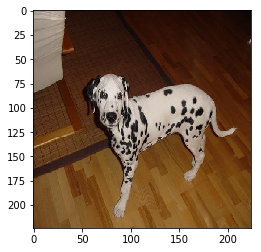

In [7]:
plt.imshow(breed_test_tensors[0]/255)

In [8]:
test = imagenet_prep(breed_test_tensors)

In [9]:
# Check that blue channel is moved to the first channel and the mean was subtracted for the first image
test[0][:,:,0].mean() + 123.68

44.244021045918359

In [10]:
test.shape

(836, 224, 224, 3)

In [11]:
def unprocess(image_tensors):
    '''
        Unprocesses the preprocessing step for imagenet.
    '''
    # Flip color channels
    RGB_tensors = image_tensors[:, :, :, ::-1]
    
    # Add RBG mean back to images
    image_net_mean = np.array([103.939,116.779,123.68])
    normal = RGB_tensors + image_net_mean
    normal = np.clip(normal, 0, 256)
    return normal

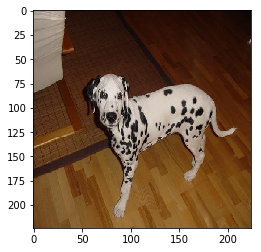

In [12]:
retest = unprocess(test)
# Check that unprocessing produces the same image as before imagenet_prep
plt.imshow(retest[0]/255)

In [13]:
breed_train_pp = imagenet_prep(breed_train_tensors)
breed_valid_pp = imagenet_prep(breed_valid_tensors)
breed_test_pp = imagenet_prep(breed_test_tensors)

#### Create Generator for Augment Training Data

In [14]:
training_generator = ImageDataGenerator(rescale=1.,
                                        rotation_range=15.0,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        shear_range=0.1,
                                        zoom_range=0.1,
                                        horizontal_flip=True,
                                        vertical_flip=False,
                                        fill_mode="reflect")

validation_generator = ImageDataGenerator(rescale=1)

In [15]:
training_data = training_generator.flow(breed_train_pp, breed_train_labels, 32)

In [ ]:
validation_data = validation_generator.flow(breed)

#### Check that augmenting the preprocessed data still produces a reasonable image

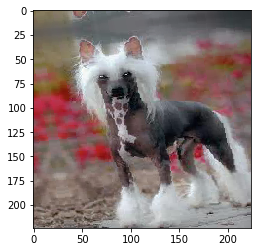

In [16]:
aug_test_up = unprocess(training_data[0][0])
plt.imshow(aug_test_up[0]/255)

#### Create Augmented Data Arrays

In [18]:
def augment_data(flow_generator, cycles):
    '''
        Function description
        
        Input:
        
        Return:
    '''
    i = 0
    batches = len(flow_generator)
    stop = batches * cycles
    for data, labels in flow_generator:
        if i == 0:
            aug_data = data
            aug_labels = labels
            i+=1
        else:
            if i%batches== 0:
                print(int(i/batches),'/',cycles,'cycles complete')
            aug_data = np.concatenate((aug_data, data), axis = 0)
            aug_labels = np.concatenate((aug_labels, labels), axis = 0)
            i+=1
        if i == stop:
            print('Data augmentation complete')
            break
    return aug_data, aug_labels

In [19]:
breed_train_aug, breed_labels_aug = augment_data(training_data, 5)

1 / 5 cycles complete
2 / 5 cycles complete


KeyboardInterrupt: 

(array([[[[ -96.68000031,  -53.77899933,  -46.93899918],
          [ -91.68000031,  -51.77899933,  -29.93899918],
          [ -97.68000031,  -62.77899933,  -42.93899918],
          ..., 
          [  35.31999969,   99.22100067,  111.06099701],
          [  35.31999969,  100.22100067,  108.06099701],
          [  37.31999969,   99.22100067,  115.06099701]],
 
         [[ -98.68000031,  -53.77899933,  -52.93899918],
          [-101.68000031,  -60.77899933,  -54.93899918],
          [ -96.68000031,  -53.77899933,  -32.93899918],
          ..., 
          [  45.31999969,   98.22100067,  118.06099701],
          [  38.31999969,   97.22100067,  110.06099701],
          [  17.31999969,   97.22100067,  102.06099701]],
 
         [[-105.68000031,  -65.77899933,  -66.93900299],
          [-104.68000031,  -63.77899933,  -57.93899918],
          [-101.68000031,  -57.77899933,  -36.93899918],
          ..., 
          [  32.31999969,   98.22100067,  113.06099701],
          [  21.31999969,   94.221

In [67]:
breed_train_aug.shape

(1672, 224, 224, 3)

## Human/Dog Detector
Build a model that predicts if there is a dog, human, both or neither in the image.

### Human Detection

In [11]:
train_inputs, train_hlabels = get_data(detector_inputs, human_det_labels, train_index)

In [12]:
train_inputs = paths_to_tensor(train_inputs)

100%|███████████████████████████████████████████████████████████████████████████| 13701/13701 [01:09<00:00, 196.83it/s]


In [17]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input

In [19]:
model = InceptionV3(include_top=False, weights='imagenet')

<tf.Tensor 'mixed10/concat:0' shape=(?, ?, ?, 2048) dtype=float32>

### Dog Detection

### Object Localization

### Split Image for Images Containing Both

## Breed Classifier for Dogs
Build a model to predict the dog breed, optimized for pictures of dogs.

### CNN from Scratch

#### Build Model

Reminder that the data arrays are named:
<ul>
    <li>breed_train_aug, breed_labels_aug</li>
    <li>breed_valid_pp, breed_valid_labels</li>
    <li>breed_test_pp, breed_test_labels</li>
</ul>

In [16]:
model = Sequential()
# Conv layer1
model.add(Conv2D(32, 3, strides=(1,1), padding='same', activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D((2,2), strides= 2, padding='same'))

# Conv layer2
model.add(Conv2D(64, 3, strides=(1,1), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2), strides= 2, padding='same'))

# Conv layer3
model.add(Conv2D(128, 3, strides=(1,1), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2), strides= 2, padding='same'))

# Conv layer4
model.add(Conv2D(256, 3, strides=(1,1), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2), strides= 2, padding='same'))

# Conv layer5
model.add(Conv2D(256, 3, strides=(1,1), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2), strides= 2, padding='same'))

#Flatten Layer
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())

#Fully Connected Layer 2
model.add(Dense(133, activation='softmax'))


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 256)       295168    
__________

In [17]:
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

#### Train Model

In [19]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 10

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch_no_da.hdf5', 
                               verbose=0, save_best_only=True)

model.fit_generator(training_data, steps_per_epoch=len(breed_train_pp)//32, epochs=epochs,
                    callbacks=[checkpointer], verbose=2, 
                    validation_data=(breed_valid_pp, breed_valid_labels))

Epoch 1/10
 - 66s - loss: 2.3423 - acc: 0.3957 - val_loss: 2.8058 - val_acc: 0.2826
Epoch 2/10
 - 62s - loss: 2.0714 - acc: 0.4591 - val_loss: 2.8959 - val_acc: 0.3054
Epoch 3/10
 - 63s - loss: 1.8972 - acc: 0.4987 - val_loss: 2.8046 - val_acc: 0.3114
Epoch 4/10
 - 63s - loss: 1.7238 - acc: 0.5328 - val_loss: 2.7134 - val_acc: 0.3186
Epoch 5/10
 - 62s - loss: 1.5979 - acc: 0.5629 - val_loss: 2.4028 - val_acc: 0.4024
Epoch 6/10
 - 65s - loss: 1.4609 - acc: 0.6012 - val_loss: 2.4941 - val_acc: 0.4096
Epoch 7/10
 - 64s - loss: 1.3236 - acc: 0.6346 - val_loss: 2.2908 - val_acc: 0.4156
Epoch 8/10
 - 65s - loss: 1.1990 - acc: 0.6686 - val_loss: 2.7070 - val_acc: 0.3952
Epoch 9/10
 - 61s - loss: 1.1058 - acc: 0.6915 - val_loss: 2.2404 - val_acc: 0.4120
Epoch 10/10
 - 62s - loss: 1.0267 - acc: 0.7078 - val_loss: 2.4309 - val_acc: 0.4048


### Build Classifier using a pretrained model

In [43]:
vgg16 = VGG16(include_top=False, weights='imagenet')

In [66]:
for layer in vgg16.layers:
    layer.trainable = False

In [45]:
model1 = vgg16.output
model1 = GlobalAveragePooling2D()(model1)
model1 = BatchNormalization()(model1)

model1 = Dense(512, activation='relu')(model1)
model1 = BatchNormalization()(model1)
model1 = Dropout(.5)(model1)

model1 = Dense(512, activation='relu')(model1)
model1 = BatchNormalization()(model1)
model1 = Dropout(.5)(model1)

model1 = Dense(133, activation='softmax')(model1)
vgg_model = Model(inputs=vgg16.input, outputs=model1)

In [67]:
vgg_model.compile(optimizer=Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [68]:
from keras.callbacks import ModelCheckpoint  
epochs = 10

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.vgg16.hdf5', 
                               verbose=0, save_best_only=True)

vgg_model.fit_generator(training_data, steps_per_epoch=len(breed_train_pp)//32, epochs=epochs,
                    callbacks=[checkpointer], verbose=2, 
                    validation_data=(breed_valid_pp, breed_valid_labels))

Epoch 1/10
 - 71s - loss: 0.1668 - acc: 0.9443 - val_loss: 0.6588 - val_acc: 0.8263
Epoch 2/10
 - 66s - loss: 0.1755 - acc: 0.9432 - val_loss: 0.6519 - val_acc: 0.8263
Epoch 3/10
 - 67s - loss: 0.1578 - acc: 0.9483 - val_loss: 0.6442 - val_acc: 0.8275
Epoch 4/10
 - 67s - loss: 0.1531 - acc: 0.9499 - val_loss: 0.6432 - val_acc: 0.8251
Epoch 5/10
 - 70s - loss: 0.1491 - acc: 0.9504 - val_loss: 0.6395 - val_acc: 0.8299
Epoch 6/10
 - 65s - loss: 0.1458 - acc: 0.9489 - val_loss: 0.6445 - val_acc: 0.8251
Epoch 7/10
 - 66s - loss: 0.1475 - acc: 0.9506 - val_loss: 0.6465 - val_acc: 0.8275
Epoch 8/10
 - 65s - loss: 0.1434 - acc: 0.9531 - val_loss: 0.6453 - val_acc: 0.8287
Epoch 9/10
 - 71s - loss: 0.1441 - acc: 0.9525 - val_loss: 0.6466 - val_acc: 0.8311
Epoch 10/10
 - 70s - loss: 0.1349 - acc: 0.9532 - val_loss: 0.6447 - val_acc: 0.8287


#### FineTune

In [64]:
for layer in vgg_model.layers[15:]:
    layer.trainable = True

vgg_model.compile(optimizer=Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [65]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch_no_da.hdf5', 
                               verbose=0, save_best_only=True)

vgg_model.fit_generator(training_data, steps_per_epoch=len(breed_train_pp)//32, epochs=epochs,
                    callbacks=[checkpointer], verbose=2, 
                    validation_data=(breed_valid_pp, breed_valid_labels))

Epoch 1/10
 - 68s - loss: 0.2950 - acc: 0.9031 - val_loss: 1.0362 - val_acc: 0.7485
Epoch 2/10
 - 64s - loss: 0.2887 - acc: 0.9017 - val_loss: 0.8474 - val_acc: 0.7832
Epoch 3/10
 - 64s - loss: 0.2700 - acc: 0.9115 - val_loss: 0.8896 - val_acc: 0.7605
Epoch 4/10
 - 64s - loss: 0.2559 - acc: 0.9197 - val_loss: 0.9144 - val_acc: 0.7425
Epoch 5/10
 - 65s - loss: 0.2301 - acc: 0.9226 - val_loss: 0.8227 - val_acc: 0.7940
Epoch 6/10
 - 65s - loss: 0.2211 - acc: 0.9271 - val_loss: 0.7813 - val_acc: 0.7928
Epoch 7/10
 - 65s - loss: 0.2377 - acc: 0.9260 - val_loss: 0.7464 - val_acc: 0.8012
Epoch 8/10
 - 65s - loss: 0.1898 - acc: 0.9377 - val_loss: 0.7644 - val_acc: 0.7916
Epoch 9/10
 - 65s - loss: 0.1990 - acc: 0.9340 - val_loss: 0.9026 - val_acc: 0.7856
Epoch 10/10
 - 65s - loss: 0.1926 - acc: 0.9406 - val_loss: 0.7960 - val_acc: 0.7964


### Build and Train Several Models
Use bottleneck features from several pretrained models

#### Inception Model

#### Resnet Model

#### VGG19

#### Xception

### Organize Models into an Ensemble

### Test the Ensemble

## Breed Classifier for Humans
Build a model that predicts a breed that looks similar to the human in the image.

### Face Detection

### Face Cropping

### Breed Classifier for Dog Faces

### Test Model on Human Faces

## Face Matching
Find a dog in the data that has a similar face as the human face.

### Eye and Nose Detector

### Process Dog Face
Adjust size and orientation so eye and nose location match the human.

## Feature Melding

### Generate Image of Human/Dog Face Combined

## Super Resolution

### Create a Super Resolution Model

### Apply Super Resolution to the Generated Image

## Final Algorithm

### Build Algorithm

### Test Algorithm